# Prepocess
Build the stock dictionary.

In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

%matplotlib inline

# Main function for submissiob

In [18]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import pickle

pd.set_option('display.max_colwidth',50000)

with open('s50.pkl', 'rb') as f:
    (stock_to_id, id_to_stock) = pickle.load(f)

m = 51 # num of stocks we use
max_n = 6000

data_mat = np.ones((m, max_n))*-1

_step = 0
step = 100
B = []
stock_state = np.zeros(m, dtype=int)

time_dict = {}
def time_to_id(time):    
    global time_dict
    if time not in time_dict.keys():
        time_dict[time] = len(time_dict.keys())
    return time_dict[time]

def build_mat(ss, history_stock_data):
    global data_mat
    '''returns a m x s data matrix'''
    df = history_stock_data
    for ind, row in df.iterrows():
        s = row['Stock Code']
        if s not in stock_to_id.keys():
            continue
        t = str(row['Time'])
        p = row['Opening Price']
        s_id = stock_to_id[s]
        t_id = time_to_id(t)
        if s_id < m and t_id < max_n:
            data_mat[s_id, t_id] = p

def predict_next_x(P, index, w=5):
    t = index-1
    x = np.zeros(P.shape[1]) # x_t+1
    if index < w:
        w = index
    for k in range(m):
        cnt = 0
        for i in range(w):
            if P[t-i, k] > 0:
                x[k] += (P[t-i, k]/P[t, k])  # formula(1)
                cnt += 1
        if cnt > 0:
            x[k] /= cnt
    return x

def predict_next_b(B, P, mask, index, epsilon, w=5):
    t = index-1
    b_t = B[-1]
    x_t1 = predict_next_x(P, index, w)
    x_mean = np.mean(x_t1)
    #print(x_t1, x_mean)
    lam = max(0.0, (epsilon-np.dot(b_t,x_t1))/(np.linalg.norm(x_t1-x_mean)**2))
    lam = min(100000, lam)
    #print(lam)
    #print(x_t1 - x_mean)
    b_t1 = b_t + lam * (x_t1 - x_mean)
    res = simplex_proj(b_t1)*mask 
    res *= 1/sum(res)
    return res #normalization

def simplex_proj(y):
    """ Projection of y onto simplex. """
    m = len(y)
    bget = False

    s = sorted(y, reverse=True)
    tmpsum = 0.

    for ii in range(m-1):
        tmpsum = tmpsum + s[ii]
        tmax = (tmpsum - 1) / (ii + 1);
        if tmax >= s[ii+1]:
            bget = True
            break

    if not bget:
        tmax = (tmpsum + s[m-1] -1)/m
        
    return np.maximum(y-tmax,0.)

def update_state(money, mask, pv, bv):
    global stock_state
    #print(stock_state)
    old_state = stock_state
    all_money = money 
    for k in range(m):
        if pv[k] > 0:
            all_money += pv[k] * stock_state[k]
    all_money = all_money*0.95
    new_state = np.zeros(m, dtype=int)
    for i in range(m):
        if pv[i] > 0:
            new_state[i] = int(all_money * bv[i] / pv[i])
    buy_code, buy_num, sell_code, sell_num = [], [], [], []
    for i in range(m):
        if i not in id_to_stock.keys():
            continue
        if new_state[i] < old_state[i] and mask[i] == 1:
            sell_code.append(id_to_stock[i])
            sell_num.append(old_state[i] - new_state[i])
        if new_state[i] > old_state[i] and mask[i] == 1:
            buy_code.append(id_to_stock[i])
            buy_num.append(new_state[i] - old_state[i])
    stock_state = new_state
    #print(buy_code)
    return sell_code, sell_num, buy_code, buy_num

def invest(data_mat, n, money, mask, w=1, epsilon=1.00001):
    global B
    
    P = data_mat
    '''
    X = np.ones_like(P)
    for i in range(m):
        for j in range(1, n):
            X[i, j] = P[i, j] / P[i, j-1]
    '''
    P = P.transpose()
    #print(P)
            
    if n == 0:
        B.append(np.array([1/m for i in range(m)]))
    else:
        b = predict_next_b(B, P, mask, n, epsilon, w)
        B.append(b)
    #print('B:', B[-1])
    sell_code, sell_num, buy_code, buy_num = update_state(money, mask, P[n], B[-1])
    return sell_code, sell_num, buy_code, buy_num

def get_avail(hist, tt):
    mask = np.zeros(m)
    for ind, row in hist.iterrows():
        s = row['Stock Code']
        t = row['Time']
        p = row['Opening Price']
        if s not in stock_to_id.keys():
            continue
        s_id = stock_to_id[s]
        if tt == t:
            mask[s_id] = 1
    return mask
    
def model(s, money, history_stock_data, investment_data, w=5, epsilon=1.000000001):
    #path='/var/www/html/information_theory/feima/test_data.csv'
    global _step
        
    
    ss = str(s)
    history_stock_data = history_stock_data[-w*520:]
    history_stock_data = history_stock_data.loc[history_stock_data['Time'] == s]
    build_mat(ss, history_stock_data)
    
    if _step > 0:
        _step -= 1
        add_data=pd.DataFrame(columns=['Time','Stocks you sell','Corresponding number of stocks you sell',
        'Stocks you buy','Corresponding number of stocks you buy']) 
        add_data=add_data.append({'Time': s}, ignore_index=True)
        return add_data
    
    _step = step-1
    mask = get_avail(history_stock_data, s)
    sell_code, sell_num, buy_code, buy_num = invest(data_mat, time_to_id(ss), money, mask, w=w, epsilon=epsilon)    
    
    add_data=pd.DataFrame(columns=['Time','Stocks you sell','Corresponding number of stocks you sell',
                                   'Stocks you buy','Corresponding number of stocks you buy']) 
                                  
    if len(sell_code) > 0 and len(buy_code) > 0:
        s1 = ', '.join(["%d"%(x) for x in sell_code])
        s2 = ', '.join(["%d"%(x) for x in sell_num])
        s3 = ', '.join(["%d"%(x) for x in buy_code])
        s4 = ', '.join(["%d"%(x) for x in buy_num])
        add_data=add_data.append({'Time': s,'Stocks you sell':s1,'Corresponding number of stocks you sell':s2,
                                  'Stocks you buy':s3,'Corresponding number of stocks you buy':s4}, ignore_index=True)    
    elif len(sell_code) > 0:
        s1 = ', '.join(["%d"%(x) for x in sell_code])
        s2 = ', '.join(["%d"%(x) for x in sell_num])
        add_data=add_data.append({'Time': s,'Stocks you sell':s1,'Corresponding number of stocks you sell':s2}, ignore_index=True)    
    elif len(buy_code) > 0:
        s1 = ', '.join(["%d"%(x) for x in buy_code])
        s2 = ', '.join(["%d"%(x) for x in buy_num])
        add_data=add_data.append({'Time': s,'Stocks you buy':s1,'Corresponding number of stocks you buy':s2}, ignore_index=True)    
    else:
        add_data=add_data.append({'Time': s}, ignore_index=True)

    return add_data

In [19]:
def test(w, epsilon):
    file = pd.read_csv('./test.csv')
    df = pd.DataFrame(file)
    #print(df['Time'].unique())
    init_c=c=100000
    for s in df['Time'].unique():    
        df_i = df.loc[df['Time'] == s]

        cc=c
        for k in range(len(stock_state)):
            if k not in id_to_stock.keys():
                continue
            #print(float(df.loc[(df['Time']==s) & (df['Stock Code']==int(id_to_stock[k]))]['Opening Price'].values[0]))
            if len(df_i.loc[df_i['Stock Code']==int(id_to_stock[k])]['Opening Price'].values)>0:
                cc+=float(df_i.loc[df_i['Stock Code']==int(id_to_stock[k])]['Opening Price'].values[0])*stock_state[k]

        #print(s, c, cc)
        #print(df_i)
        res = model(s, c, df_i, _, w, epsilon)
        #print(res)
        #print((res.at[0, 'Stocks you buy']))
        if not pd.isnull(res.at[0, 'Stocks you sell']):
            sell_s = res.at[0, 'Stocks you sell'].split(', ')
            sell_n = res.at[0, 'Corresponding number of stocks you sell'].split(', ')
            for k in range(len(sell_s)):
                c += float(df_i.loc[df_i['Stock Code']==int(sell_s[k])]['Opening Price'].values[0]*int(sell_n[k]))

        if not pd.isnull(res.at[0, 'Stocks you buy']):
            buy_s = res.at[0, 'Stocks you buy'].split(', ')
            buy_n = res.at[0, 'Corresponding number of stocks you buy'].split(', ')
            for k in range(len(buy_s)):
                #print(df.loc[(df['Time']==s) & (df['Stock Code']==int(buy_s[k]))]['Opening Price'].values[0])
                c -= float(df_i.loc[df_i['Stock Code']==int(buy_s[k])]['Opening Price'].values[0]*int(buy_n[k]))
    rate=1.0*cc/init_c
    return rate

## step = 10, 50 stocks

In [20]:
test_res = []
for w in [5, 8, 10, 20, 50]:
    for ep in [1.01, 1.001, 1.0001, 1.00001, 1.000001]:
        r = test(w, ep)
        print(w, ep, r)
        test_res.append((w, ep, r))

5 1.01 1.0406032999999997
5 1.001 2.0306417
5 1.0001 2.9672229999999993
5 1.00001 3.8499597
5 1.000001 4.687457299999999
8 1.01 5.482576900000001
8 1.001 6.2450196
8 1.0001 6.967723200000003
8 1.00001 7.6484421000000005
8 1.000001 8.292370600000002
10 1.01 8.904665499999998
10 1.001 9.484528700000002
10 1.0001 10.045557599999999
10 1.00001 10.573190599999998
10 1.000001 11.070674600000002
20 1.01 11.542750799999999
20 1.001 11.9906545
20 1.0001 12.424808800000001
20 1.00001 12.833709400000002
20 1.000001 13.217818299999998
50 1.01 13.579266600000004
50 1.001 13.920168000000002
50 1.0001 14.2453294
50 1.00001 14.5644088
50 1.000001 14.864231700000003


In [4]:
for w in [50, 100, 200, 500, 1000, 2000]:
    for ep in [1.0000001, 1.00000001, 1.000000001]:
        r = test(w, ep)
        print(w, ep, r)
        test_res.append((w, ep, r))

50 1.0000001 21.429387899999995
50 1.00000001 22.0505974
50 1.000000001 22.657582599999998
100 1.0000001 23.252854099999997
100 1.00000001 23.82293019999999
100 1.000000001 24.466115
200 1.0000001 25.022308300000002
200 1.00000001 25.523173
200 1.000000001 26.013277399999996
500 1.0000001 26.502184300000003
500 1.00000001 27.270637400000016
500 1.000000001 27.4801436
1000 1.0000001 27.7907473
1000 1.00000001 28.143359
1000 1.000000001 28.523181400000006
2000 1.0000001 29.604492400000005
2000 1.00000001 29.743420799999996
2000 1.000000001 29.994816800000002


In [10]:
for w in [5000, 10000, 15000]:
    for ep in [1.0000001]:
        r = test(w, ep)
        print(w, ep, r)
        test_res.append((w, ep, r))

5000 1.0000001 30.293331800000008
10000 1.0000001 30.6239408
15000 1.0000001 31.706982200000002


## step = 500, 50 stocks

In [11]:
step = 500
print(test(1000, 1.000000001))

31.7551015


# Demonstration

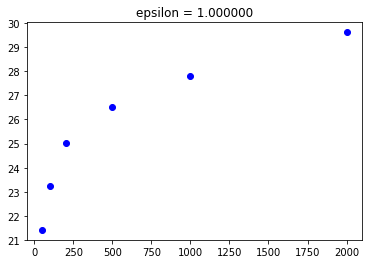

In [9]:
x, y = [], []
for (w, ep, r) in test_res:
    if ep == 1.0000001:
        x.append(w)
        y.append(r)
        
plt.title('epsilon = %f' % ep)
plt.plot(x, y, 'bo')
plt.show()